# Volatility basket strategy

- Same as v01
- Use 7d volatility for rebalance instead of 30d

# Set up

Set up Trading Strategy data client.


In [33]:
import logging

from tradingstrategy.client import Client
from tradeexecutor.utils.notebook import setup_charting_and_output, OutputMode

client = Client.create_jupyter_client()

# Set up drawing charts in interactive vector output mode.
# This is slower. See the alternative commented option below.
# setup_charting_and_output(OutputMode.interactive)

# Set up rendering static PNG images.
# This is much faster but disables zoom on any chart.
setup_charting_and_output(OutputMode.static, image_format="png", width=1500, height=1000)


Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy


# Parameters

- Strategy parameters define the fixed and grid searched parameters

In [34]:
import datetime

import pandas as pd

from tradingstrategy.chain import ChainId
from tradeexecutor.strategy.default_routing_options import TradeRouting
from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.parameters import StrategyParameters


class Parameters:
    """Parameteres for this strategy.

    - Collect parameters used for this strategy here

    - Both live trading and backtesting parameters
    """

    id = "04-vol-binance-data-skeleton-meme-weekly-trail" # Used in cache paths

    cycle_duration = CycleDuration.cycle_1h

    #
    # Trading universe setup
    #

    candle_time_bucket = TimeBucket.h1

    #
    # Strategy parameters
    #
    minimum_volatility_threshold = 0.005  # clip zero assets by volatility (if needed)
    allocation = 0.98  # How much cash to allocate to the portfolio (we need leave some in the account for rounding/costs)
    max_assets_in_portfolio = 3  # Amount of assets in the basket
    max_pairs_per_month = 3  # How many pairs we pick in the monthly inclusion criteria
    minimum_rebalance_trade_threshold = 0.2  # % of portfolio composition must change before triggering rebalacne
    individual_rebalance_min_threshold_usd = 100  # Don't make buys less than this amount

    # For the length of trailing sharpe used in inclusion criteria
    inclusion_criteria_bars = pd.Timedelta("7d") // candle_time_bucket.to_timedelta()
    rebalance_volalitity_bars = pd.Timedelta("7d") // candle_time_bucket.to_timedelta()
    
    #
    # Live trading only
    #
    chain_id = ChainId.ethereum
    routing = TradeRouting.default  # Pick default routes for trade execution
    required_history_period = None  # Fill in for live trading

    #
    # Backtesting only
    #
    backtest_start = datetime.datetime(2022, 1, 15)
    backtest_end = datetime.datetime(2024, 8, 15)
    backtest_trading_fee = 0.0006  # Assumed taker fee for trades
    initial_cash = 10_000


parameters = StrategyParameters.from_class(Parameters)  # Convert to AttributedDict to easier typing with dot notation



# Trading pairs and market data

- Construct a special trading universe for backesting from pregenerated Parquet files for OHLCV and liquidity

- Load prefiltered data

- Build a list of trading pairs that are not
    - Stable/stable
    - Supported quote token
    - Have an accetable trading fee
    - Meets the minimum liquidity requirement in some point of history (see the prefilter script)


**Note**: Currently WETH pairs are ignored, only USDC nonimated pairs are considered.

In [35]:
from pathlib import Path

import pandas as pd

from tradeexecutor.utils.binance import create_binance_universe
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradingstrategy.client import Client
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
from tradeexecutor.strategy.universe_model import UniverseOptions


#: Build a list of meme coins for memecoin basked
#: Handpicked from https://coinmarketcap.com/view/memes/
#: and https://www.binance.com/en/markets/coinInfo-Meme
MEME_TOKENS = [
    "DOGE",
    "SHIB",
    "PEPE",
    "WIF",
    "FLOKI",
    "BONK",
    # "BRETT", # Not available on Binance
    # "POPCAT",  # Not available on Binance
    # "MOG", # Not available on Binance
    # "MEW",  # Not available on Binance
    "MEME",
    "1000SATS",
    "ORDI",
    "BOME",
    "PEOPLE",
    "BANANA"
]

#: Build a list of meme coins for memecoin basked
#: Handpicked from https://www.binance.com/en/markets/coinInfo-Meme
DEFI_TOKENS = [
    "UNI",
    "AAVE",
    "MKR",
    "JUP",
    "CAKE",
    "1INCH",
    "SUSHI",
    "YFI",
    "JOE",
    "GMX",
    "OSMO",
    "ZRX",
    "MLN",
    "PERP",
    "CREAM",
    "QUICK",
    "SNX",
    "CRV"
]

#: Assets used as the buy-and-hold benchmark values for our strategy,
#: but not traded by this strategy
BENCHMARK_TOKENS = [
    "BTC",
    "ETH"
]

#: What data to download
ALL_TOKENS = MEME_TOKENS + BENCHMARK_TOKENS

def create_trading_universe(
    timestamp: datetime.datetime,
    client: Client,
    execution_context: ExecutionContext,
    universe_options: UniverseOptions,
) -> TradingStrategyUniverse:
    """Create the trading universe."""

    tickers = {f"{m}USDT" for m in ALL_TOKENS}

    strategy_universe = create_binance_universe(
        list(tickers),
        candle_time_bucket=Parameters.candle_time_bucket,
        # stop_loss_time_bucket=Parameters.stop_loss_time_bucket,
        start_at=universe_options.start_at,
        end_at=universe_options.end_at,
        trading_fee_override=Parameters.backtest_trading_fee,
    )
    return strategy_universe


strategy_universe = create_trading_universe(
    None,
    client,
    notebook_execution_context,
    UniverseOptions.from_strategy_parameters_class(Parameters, notebook_execution_context)
)


# Indicators

- Precalculate indicators used by the strategy

In [36]:
import pandas as pd
import numpy as np

from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorSet, IndicatorSource
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse


def trailing_sharpe(close: pd.Series, window_length_bars: int) -> pd.Series:
    """Calculate trailing 30d or so returns / standard deviation.

    :param length:
        Trailing period. 
    
    :return:
        Rolling cumulative returns / rolling standard deviation

        Note that this trailing sharpe is not annualised.
    """
    price_diff = close.pct_change()
    rolling_cumulative_return = (1 + price_diff).rolling(window=window_length_bars).apply(np.prod) - 1
    rolling_std = price_diff.rolling(window=window_length_bars).std()
    return rolling_cumulative_return / rolling_std  


def trailing_sharpe_business_month(close, window_length_bars, pair, dependency_resolver) -> pd.Series:
    """Snap the trailing returns to business month start day/hour."""

    hour = 8  # 8AM

    def first_day_8am(group):
        target_time = group.index[0].floor('D') + pd.Timedelta(hours=hour)
        return group.loc[target_time] if target_time in group.index else np.NaN
        #return group.loc.get(target_time)

    trailing_volatility = dependency_resolver.get_indicator_data(
        "trailing_sharpe",
        pair=pair,
        parameters={"window_length_bars": window_length_bars},
    )    

    first_day_series = trailing_volatility.resample('MS').apply(first_day_8am)
    first_day_series.attrs["time_bucket"] = TimeBucket.d30  # Hint this is monthly data
    return first_day_series


def volatility(close: pd.Series, window_length_bars: int) -> pd.Series:
    """Calculate the rolling volatility for rebalancing the index for each decision cycle."""
    price_diff = close.pct_change()
    rolling_std = price_diff.rolling(window=window_length_bars).std()
    return rolling_std
    

def create_indicators(
    timestamp: datetime.datetime | None,
    parameters: StrategyParameters,
    strategy_universe: TradingStrategyUniverse,
    execution_context: ExecutionContext
):
    """Create indicator descriptions.
    
    - Indicators are automatically recalculated and cached by the backtest runner,
      if indicator Python function body or parameters change
    """
    indicators = IndicatorSet()
    indicators.add(
        "trailing_sharpe",
        trailing_sharpe,
        {"window_length_bars": parameters.inclusion_criteria_bars},
        IndicatorSource.close_price,
    )
    indicators.add(
        "volatility",
        volatility,
        {"window_length_bars": parameters.rebalance_volalitity_bars},
        IndicatorSource.close_price,
    )
    indicators.add(
        "trailing_sharpe_business_month",
        trailing_sharpe_business_month,
        {"window_length_bars": parameters.inclusion_criteria_bars},
        IndicatorSource.close_price,
        order=2,  # After trailing_sharpe
    )    
    return indicators


# Trading algorithm

- Describe out trading strategy as code

In [37]:
from tradingstrategy.utils.time import floor_pandas_month
from tradeexecutor.state.identifier import TradingPairIdentifier
from tradeexecutor.strategy.weighting import weight_by_1_slash_signal
from tradeexecutor.strategy.alpha_model import AlphaModel
from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.pandas_trader.strategy_input import StrategyInput, StrategyInputIndicators
from tradeexecutor.state.visualisation import PlotKind

_included_pairs_cache: dict[pd.Timestamp, list[TradingPairIdentifier]] = {}


def _calculate_sorted_pairs_for_inclusion_criteria(
    timestamp: pd.Timestamp,
    trailing_sharpe_business_month: dict[TradingPairIdentifier, pd.Series],
) -> list[TradingPairIdentifier]:
    """"Get included pairs in this month.

    - Core calcualtion logic
     
    - We sort pairs by their std-adjusted returns
    
    - We pick N top

    :return:
        Sorted results of the top picks.

        Note that the list might be shorter than asked count, 
        because some pairs might not trade yet.
    """

    results = []
    for pair, trailing_sharpe_business_month in trailing_sharpe_business_month.items():

        if pair.base.token_symbol in BENCHMARK_TOKENS:
            # Don't trade on benchmark tokens
            continue

        val = trailing_sharpe_business_month.get(timestamp)
        if val is not None:
            results.append((pair, val))
    results.sort(key=lambda tpl: tpl[1], reverse=True)
    return [tpl[0] for tpl in results]


def get_included_pairs_per_month(
    input: StrategyInputIndicators,
):
    """Get included pairs during this month.    
    
    - Cached per start of the month
    """

    timestamp = input.timestamp
    indicators = input.indicators
    floored_ts = floor_pandas_month(timestamp)
    cached = _included_pairs_cache.get(floored_ts)
    if cached is None:

        # Built the input per-pair series for the calculations
        trailing_sharpe_business_month_per_pair = {
            pair: indicators.get_indicator_series("trailing_sharpe_business_month", pair=pair, unlimited=True) for pair in strategy_universe.iterate_pairs()
        }

        data = _calculate_sorted_pairs_for_inclusion_criteria(
            floored_ts,
            trailing_sharpe_business_month_per_pair,
        )
        cached = _included_pairs_cache[floored_ts] = data 

    return cached


def decide_trades(
    input: StrategyInput,
) -> list[TradeExecution]:
    """For each strategy tick, generate the list of trades."""
    # 
    # Decidion cycle setup.
    # Read all variables we are going to use for the decisions.
    #
    parameters = input.parameters
    position_manager = input.get_position_manager()
    state = input.state
    timestamp = input.timestamp
    indicators = input.indicators
    alpha_model = AlphaModel(timestamp)

    available_pairs = get_included_pairs_per_month(input)
    top_pairs = available_pairs[0:parameters.max_pairs_per_month]

    assets_chosen_count = 0

    for pair in top_pairs:

        volatility = indicators.get_indicator_value("volatility", pair=pair)
        if volatility is None:
            # Back buffer has not filled up yet with enough data,
            # skip to the next pair
            continue

        if volatility >= parameters.minimum_volatility_threshold:
            # Include this pair for the ranking for each tick
            alpha_model.set_signal(
                pair,
                volatility,
            )
            assets_chosen_count += 1

        # Our trading starts as soon as we have valid
        # data for at least the one trading pair
        state.mark_ready(timestamp)

    #
    # Do 1/volatility weighting
    #
    # Select max_assets_in_portfolio assets in which we are going to invest
    alpha_model.select_top_signals(parameters.max_assets_in_portfolio)
    alpha_model.assign_weights(method=weight_by_1_slash_signal)
    alpha_model.normalise_weights()

    # Load in old weight for each trading pair signal,
    # so we can calculate the adjustment trade size
    alpha_model.update_old_weights(state.portfolio)

    # Calculate how much dollar value we want each individual position to be on this strategy cycle,
    # based on our total available equity
    portfolio = position_manager.get_current_portfolio()
    portfolio_target_value = portfolio.get_total_equity() * parameters.allocation
    alpha_model.calculate_target_positions(position_manager, portfolio_target_value)

    # Shift portfolio from current positions to target positions
    # determined by the alpha signals if the basket value mixture changes
    # more than rebalance_threshold_usd USD
    rebalance_threshold_usd = state.portfolio.get_total_equity() * parameters.minimum_rebalance_trade_threshold
    trades = alpha_model.generate_rebalance_trades_and_triggers(
        position_manager,
        min_trade_threshold=rebalance_threshold_usd,  
        invidiual_rebalance_min_threshold=parameters.individual_rebalance_min_threshold_usd,
    )

    if input.is_visualisation_enabled():
        # Save alpha model debug data to diagnose the strategy
        # (Only when not grid search/optimiser)
        # SLOW
        # state.visualisation.add_calculations(timestamp, alpha_model.to_dict())

        # Plot how many assets we have available this month
        state.visualisation.plot_indicator(
            timestamp,
            "assets_available",
            PlotKind.technical_indicator_detached,
            len(available_pairs),            
        )

        # Plot how many assets we have chosen for this cycle
        state.visualisation.plot_indicator(
            timestamp,
            "assets_chosen",
            PlotKind.technical_indicator_detached,
            assets_chosen_count,
        )        

    return trades  # Return the list of trades we made in this cycle

# Backtest

- Run the backtest

In [38]:
from tradeexecutor.backtest.backtest_runner import run_backtest_inline

result = run_backtest_inline(
    name=parameters.id,
    engine_version="0.5",
    decide_trades=decide_trades,
    create_indicators=create_indicators,
    client=client,
    universe=strategy_universe,
    parameters=parameters,
    # log_level=logging.INFO,
    max_workers=1,
)

state = result.state

trade_count = len(list(state.portfolio.get_all_trades()))
print(f"Backtesting completed, backtested strategy made {trade_count} trades")

Reading cached indicators trailing_sharpe, volatility, trailing_sharpe_business_month for 14 pairs, using 8 th…

Using indicator cache /Users/moo/.cache/indicators/centralised-exchange_1h_14_2022-01-15-2024-08-15_nff


  0%|          | 0/81475200 [00:00<?, ?it/s]

Backtesting completed, backtested strategy made 296 trades


# Equity curve

- Equity curve shows how your strategy accrues value over time

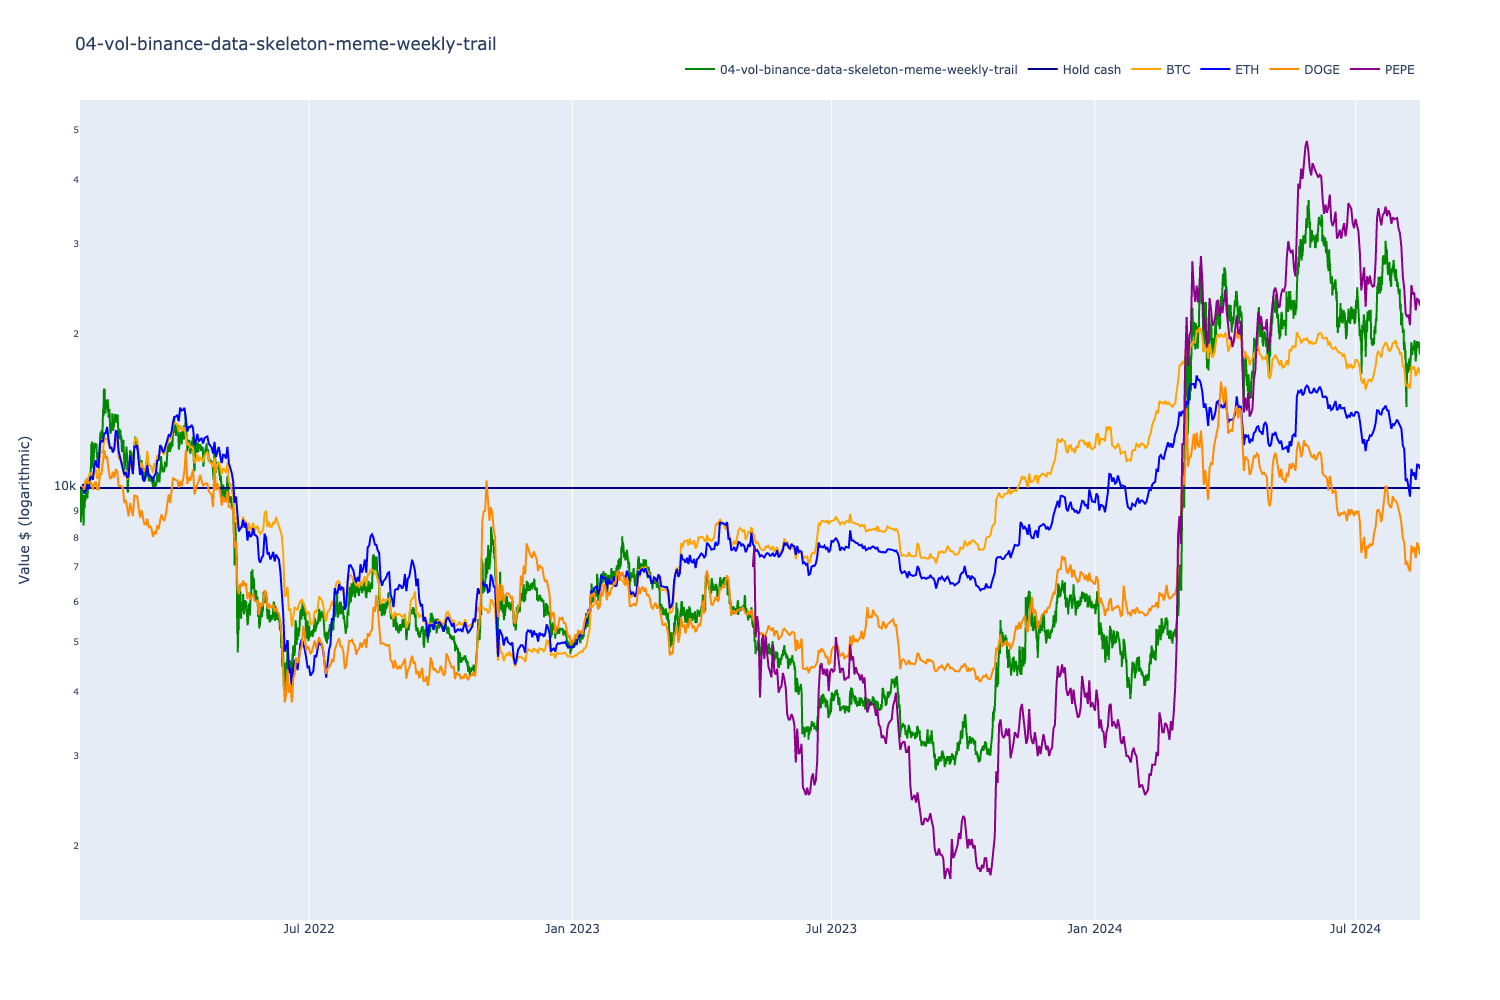

In [39]:
import pandas as pd
from tradeexecutor.analysis.multi_asset_benchmark import get_benchmark_data
from tradeexecutor.visual.benchmark import visualise_equity_curve_benchmark

benchmark_indexes = get_benchmark_data(
    strategy_universe,
    cumulative_with_initial_cash=state.portfolio.get_initial_cash(),
    max_count=4,
    start_at=state.get_trading_time_range()[0],
    interesting_assets=["BTC", "ETH", "DOGE", "PEPE"]
)

fig = visualise_equity_curve_benchmark(
    state=state,    
    benchmark_indexes=benchmark_indexes,
    height=800,
    log_y=True,
)

fig.show()

# Trading pair breakdown

- Trade success for each trading pair



In [40]:
from tradeexecutor.analysis.multipair import analyse_multipair
from tradeexecutor.analysis.multipair import format_multipair_summary

multipair_summary = analyse_multipair(state)
format_multipair_summary(multipair_summary, sort_column="Total return %")

# Performance metrics

- Display portfolio performance metrics
- Compare against buy and hold matic using the same initial capital

**Note**: Some of these metrics might be incorrect due to slow start of the strategy

In [41]:
from tradeexecutor.analysis.multi_asset_benchmark import compare_strategy_backtest_to_multiple_assets

compare_strategy_backtest_to_multiple_assets(
    state,
    strategy_universe,
    display=True,
)

Strategy                  BTC  \
Start Period                      2022-01-15           2022-01-15   
End Period                        2024-08-14           2024-08-14   
Risk-Free Rate                          0.0%                 0.0%   
Time in Market                        100.0%               100.0%   
Cumulative Return                     83.19%               71.71%   
CAGR﹪                                 26.43%                23.3%   
Sharpe                                  0.73                 0.66   
Prob. Sharpe Ratio                    88.65%               85.45%   
Sortino                                 1.19                 0.97   
Sortino/√2                              0.84                 0.69   
Omega                                   1.12                 1.12   
Max Drawdown                         -81.35%              -66.52%   
Longest DD Days                          755                  683   
Gain/Pain Ratio                         0.12                 0.11   
Gain/Pain (1M)                          0.73                 0.59   
Payoff Ratio                            1.12                 1.15   
Profit Factor                           1.12                 1.11   
Common Sense Ratio                      1.27                 1.21   
CPC Index                               0.63                 0.65   
Tail Ratio                              1.13                  1.1   
Outlier Win Ratio                       4.24                 6.21   
Outlier Loss Ratio                      3.48                  5.4   
MTD                                  -20.67%               -8.38%   
3M                                    -16.9%               -1.18%   
6M                                   265.17%               21.33%   
YTD                                  217.29%               43.47%   
1Y                                   347.88%              106.41%   
3Y (ann.)                             26.43%                23.3%   
5Y (ann.)                             26.43%                23.3%   
10Y (ann.)                            26.43%                23.3%   
All-time (ann.)                       26.43%                23.3%   
Avg. Drawdown                         -25.4%              -11.84%   
Avg. Drawdown Days                        92                   75   
Recovery Factor                         1.02                 1.08   
Ulcer Index                             0.57                 0.38   
Serenity Index                          0.09                 0.08   
Annualised return (raw)             0.264344                  NaN   
Benchmark start          2022-01-22 01:00:00  2022-01-22 01:00:00   
Start price                                -             36483.15   
End price                                  -             58993.99   
Price diff                                 -                 0.62   
Multiplier X                               -                 1.62   
Candle freq                                -      0 days 01:00:00   

                                         ETH  
Start Period                      2022-01-15  
End Period                        2024-08-14  
Risk-Free Rate                          0.0%  
Time in Market                        100.0%  
Cumulative Return                     10.93%  
CAGR﹪                                   4.1%  
Sharpe                                   0.4  
Prob. Sharpe Ratio                    73.79%  
Sortino                                 0.59  
Sortino/√2                              0.41  
Omega                                   1.12  
Max Drawdown                         -71.78%  
Longest DD Days                          702  
Gain/Pain Ratio                         0.06  
Gain/Pain (1M)                          0.36  
Payoff Ratio                            1.08  
Profit Factor                           1.06  
Common Sense Ratio                      1.21  
CPC Index                               0.57  
Tail Ratio                              1.14  
Outlier Win 

# Trading statistics

- Display summare about made trades

In [42]:
from tradeexecutor.analysis.trade_analyser import build_trade_analysis

analysis = build_trade_analysis(state.portfolio)
summary = analysis.calculate_summary_statistics()
display(summary.to_dataframe())

# Assets available

- How many assets we have available for trading and chosen for the basket for each month
- We are working on somewhat small trading universes so this might give hints of bad perforamnce


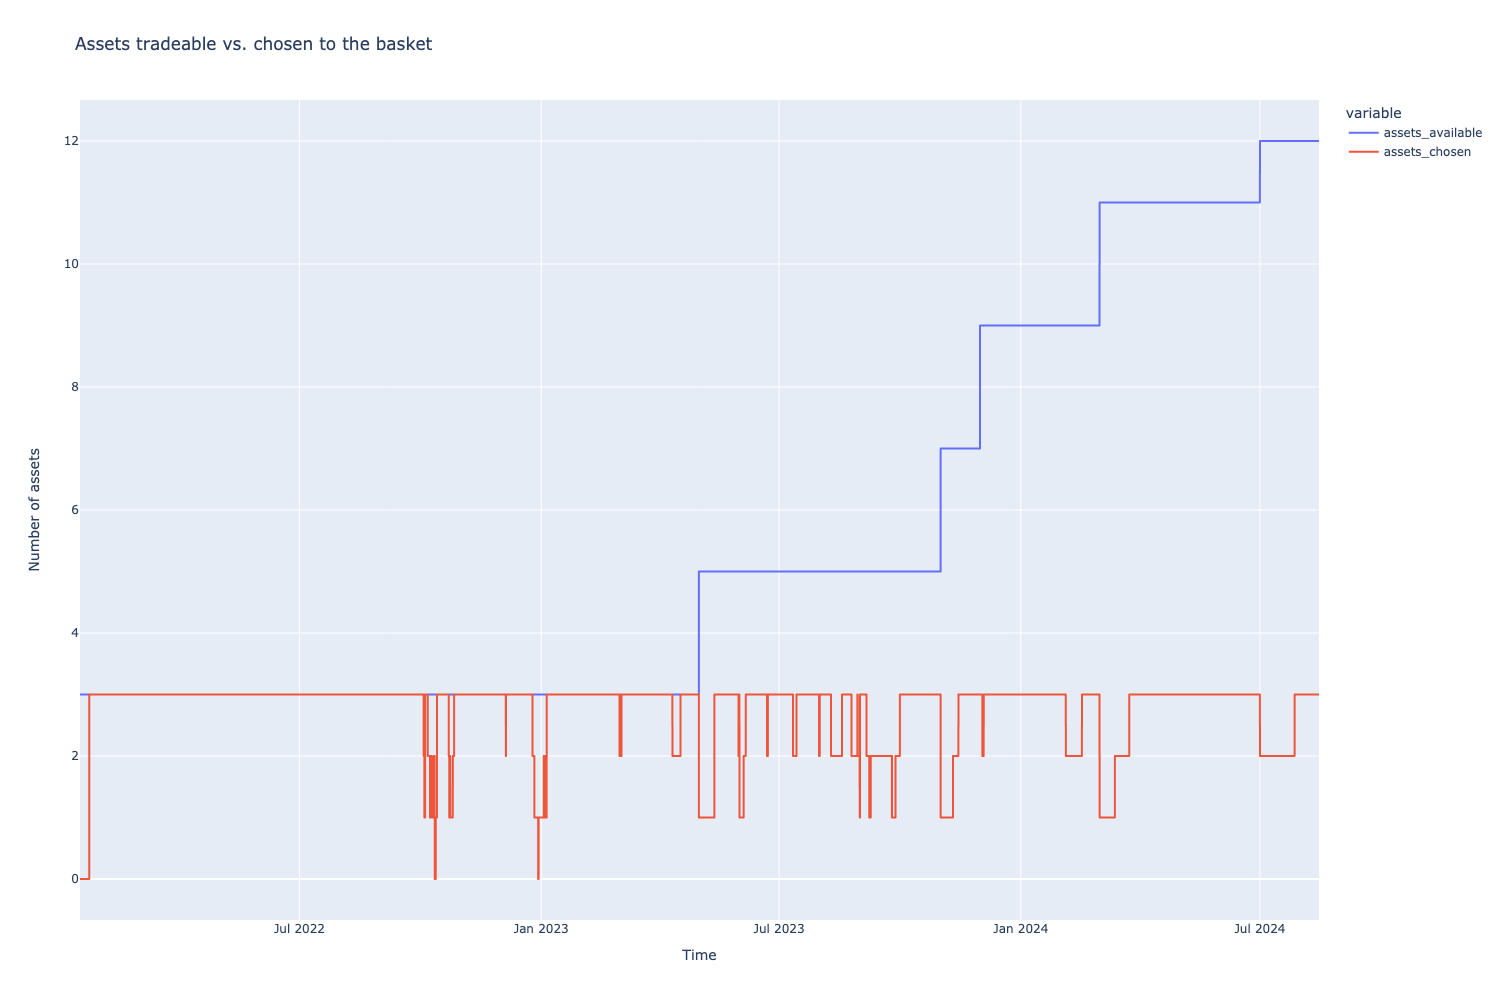

In [43]:
import plotly.express as px

visualisation = state.visualisation

df = pd.DataFrame({
    "assets_available": visualisation.get_series("assets_available"),
    "assets_chosen": visualisation.get_series("assets_chosen")
})

fig = px.line(df, title='Assets tradeable vs. chosen to the basket')
fig.update_yaxes(title="Number of assets")
fig.update_xaxes(title="Time")
fig.show()

# Example indicator data

- Examine the raw indicator data of an individual trading pair

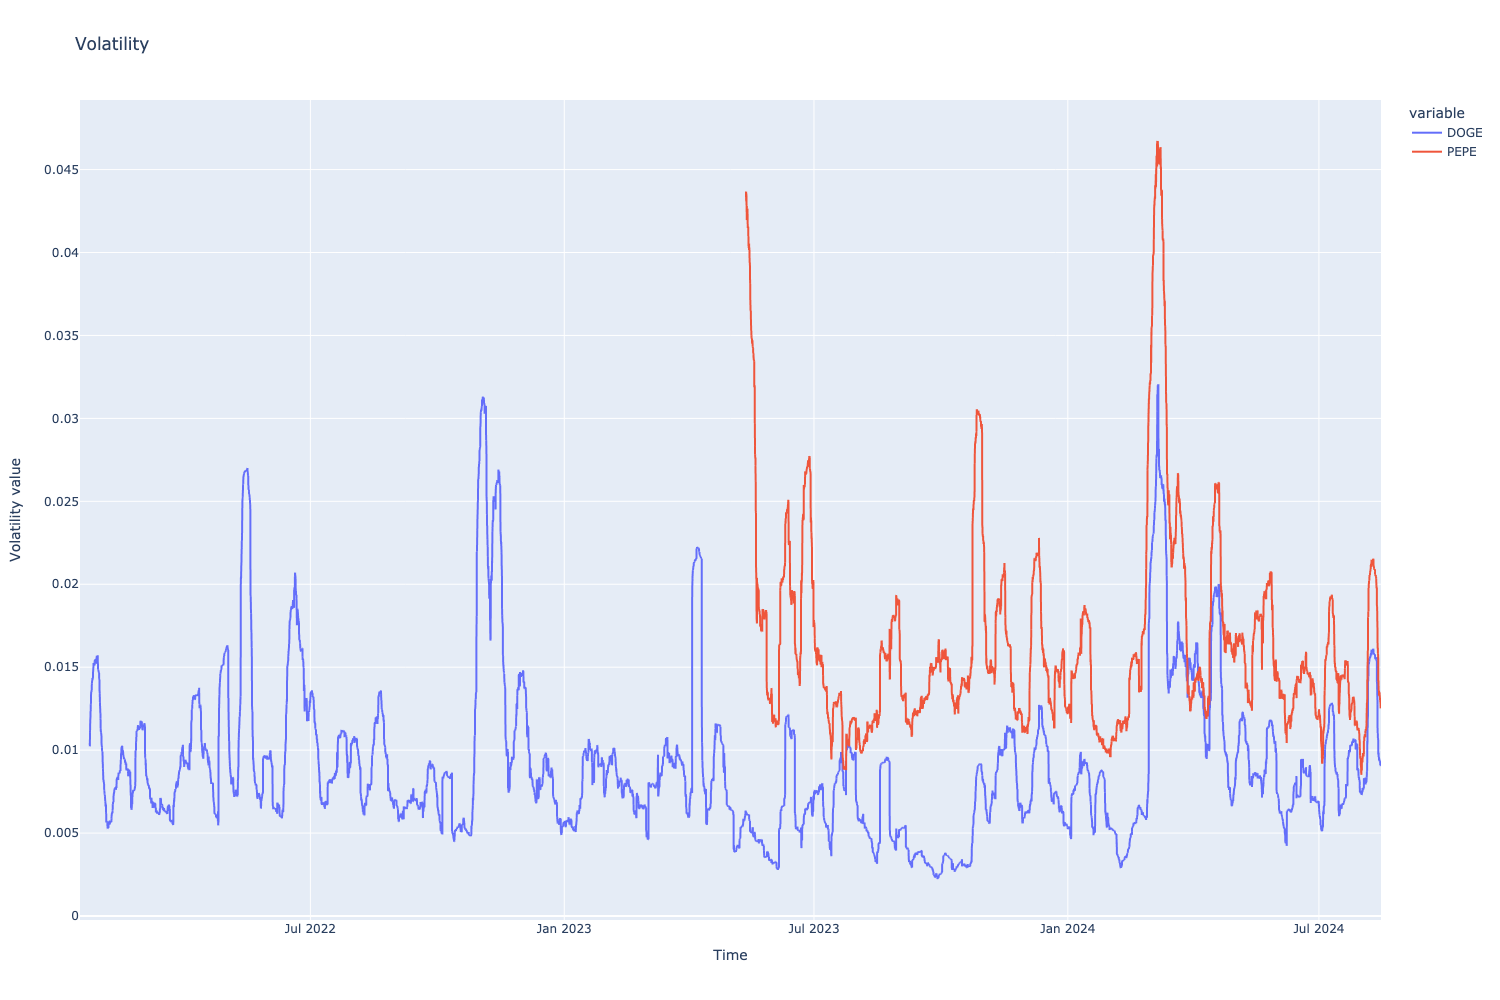

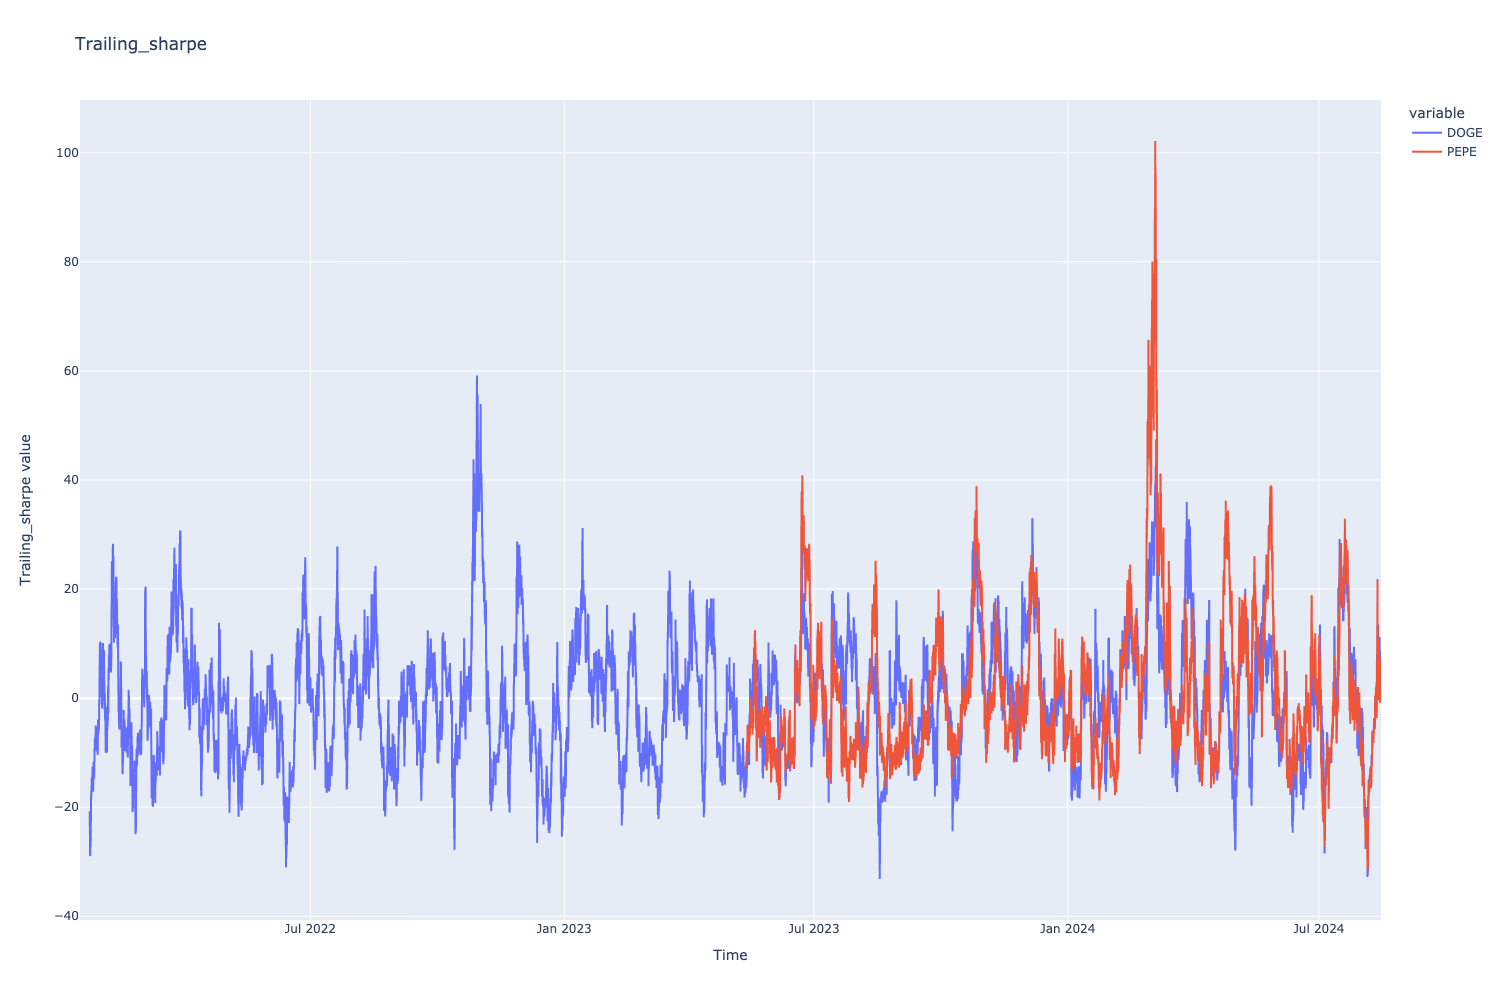

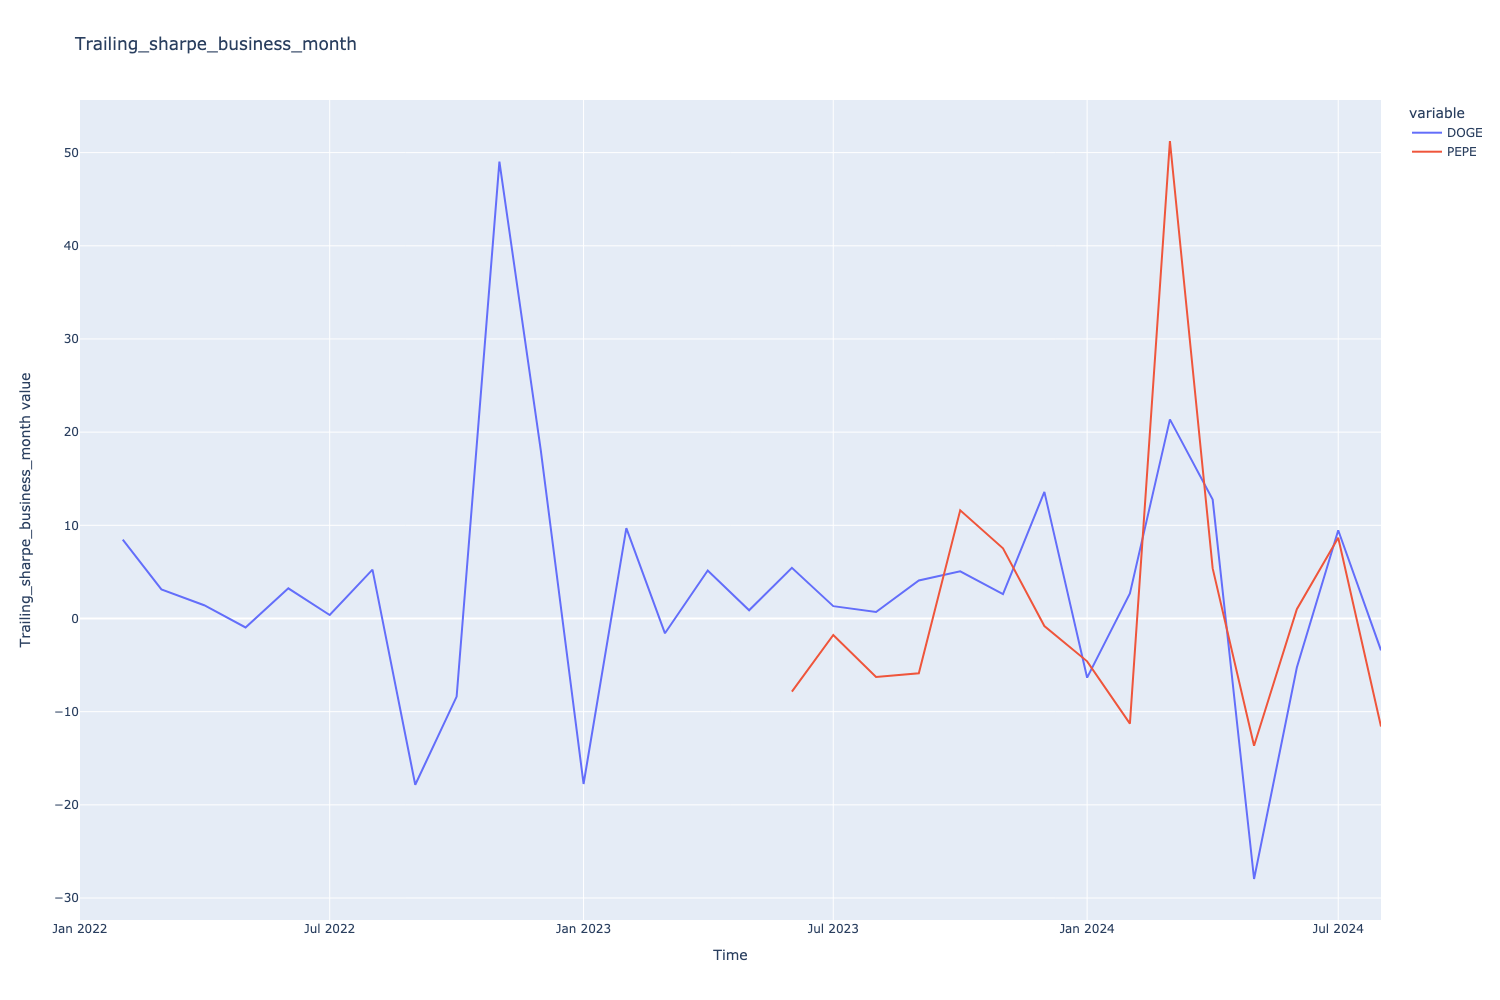

In [44]:
import plotly.express as px

for indicator_name in ["volatility", "trailing_sharpe", "trailing_sharpe_business_month"]:

    data = {}
    for symbol in ["DOGE", "PEPE"]:

        pair = strategy_universe.get_pair_by_human_description([
            ChainId.centralised_exchange, 
            "binance", 
            symbol,
            "USDT"
        ])

        # Pull the pair and its close price we are detecting regimes for
        indicators = result.indicators

        data[symbol] = series = indicators.get_indicator_series(indicator_name, pair=pair)

    df = pd.DataFrame(data)
    fig = px.line(df, title=f"{indicator_name.capitalize()}")
    fig.update_layout(showlegend=True)
    fig.update_yaxes(title=f"{indicator_name.capitalize()} value")
    fig.update_xaxes(title="Time")
    fig.show()


#

# Rolling Sharpe

- See how the six months rolling Sharpe ratio changes over time

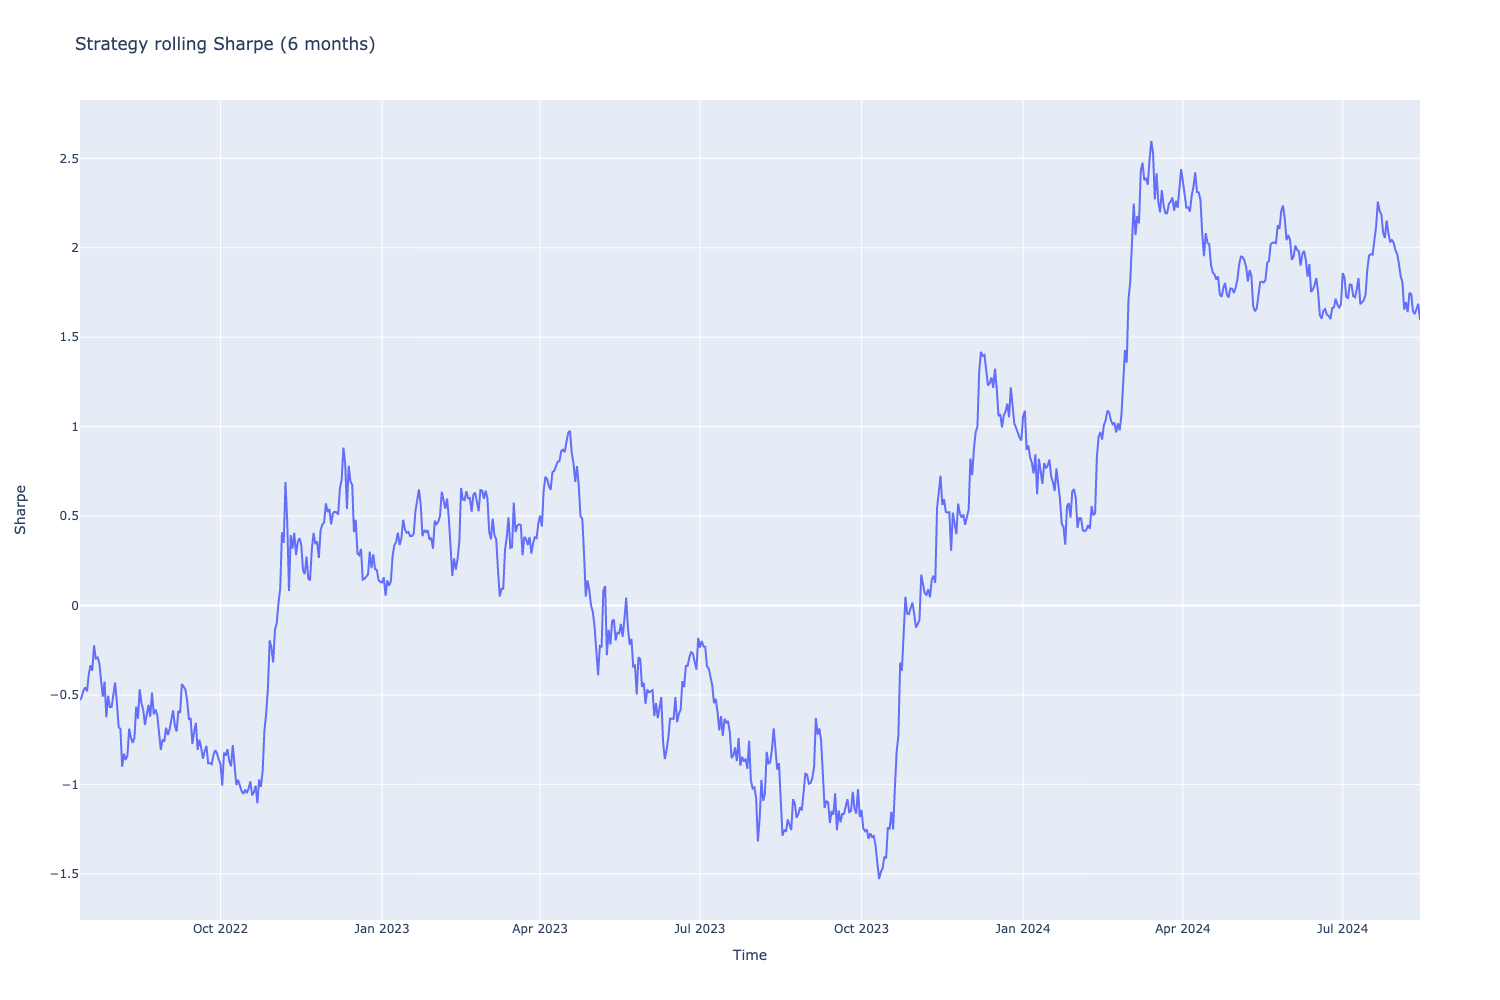

In [45]:
import plotly.express as px

from tradeexecutor.visual.equity_curve import calculate_equity_curve, calculate_returns
from tradeexecutor.visual.equity_curve import calculate_rolling_sharpe

equity = calculate_equity_curve(state)
returns = calculate_returns(equity)

rolling_sharpe = calculate_rolling_sharpe(
    returns,
    freq="D",
    periods=180,
)

fig = px.line(rolling_sharpe, title='Strategy rolling Sharpe (6 months)')
fig.update_layout(showlegend=False)
fig.update_yaxes(title="Sharpe")
fig.update_xaxes(title="Time")
fig.show()